In [1]:
print("Hello LangGraph!")

Hello LangGraph!


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

docs = DirectoryLoader(".", glob="*.txt", show_progress=True).load() # loads all text files in the current directory

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

new_docs = text_splitter.split_documents(docs)

db = Chroma.from_documents(new_docs, embeddings, persist_directory="chroma_db")
retriever = db.as_retriever(search_kwargs={"k": 2})

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


## Agenda:
- llm_with_tools
- Memeory
- ToolNodes

In [3]:
from typing import Annotated, Literal, TypedDict

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode


from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate

In [4]:
def call_model(state: MessagesState):
    message = state['messages']
    response = llm.invoke(message)
    return {"messages": response}

In [5]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)
app = workflow.compile()

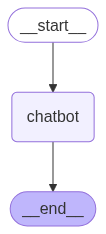

In [6]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [7]:
input = {"messages":["Hello, tell me a joke."]}

app.invoke(input)

{'messages': [HumanMessage(content='Hello, tell me a joke.', additional_kwargs={}, response_metadata={}, id='65ae6129-8087-4f40-8b96-1e3b1ff6b807'),
  AIMessage(content="Why don't scientists trust atoms? \n\nBecause they make up everything!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--f59984c9-a3bd-4670-ba3c-1e7b251774d4-0', usage_metadata={'input_tokens': 7, 'output_tokens': 17, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}})]}

In [8]:
@tool
def search(query: str) -> str:
    """this is custom tool."""
    if "langgraph" in query:
        return "langgraph is a graph-based programming language."
    return "I don't know the answer to that question."

In [9]:
search.invoke("what is a document loader?")

"I don't know the answer to that question."

In [10]:
tools = [search]
tool_node = ToolNode(tools)

llm_with_tool = llm.bind_tools(tools)

In [11]:
llm_with_tool.invoke("Hi Can you search for a langgraph?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "langgraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--0e11c145-3b59-496b-86de-e8b12951d2b1-0', tool_calls=[{'name': 'search', 'args': {'query': 'langgraph'}, 'id': '1d67dd50-6643-4dd8-9f1b-138767d4135c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 19, 'output_tokens': 4, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [12]:
def call_model(state : MessagesState):
    message = state['messages']
    response = llm_with_tool.invoke(message)
    return {"messages": [response]}

In [13]:
call_model({"messages":["What is langgraph ?"]})

{'messages': [AIMessage(content='I am sorry, I do not have access to external websites or specific files online, including information about "langgraph".  Therefore, I cannot provide a definition or description.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--fe84b011-bea7-4612-92c0-9d0bfa357cc9-0', usage_metadata={'input_tokens': 15, 'output_tokens': 36, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}})]}

In [14]:
def route_function(state: MessagesState):
    message = state['messages'][-1]
    if message.tool_calls:
        return "tools"
    else:
        return END


In [15]:
memory = MemorySaver()

In [16]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent",call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", 
                               route_function,
                               {
                                   "tools": "tools",
                                    END: END
                               })

app = workflow.compile(checkpointer=memory)

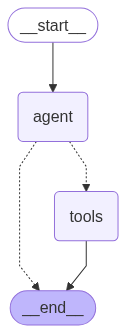

In [17]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [18]:
app.invoke({"messages":["What is langgraph?"]}, config={"configurable": {"thread_id": "thread-1"}}, stream_mode="values")

{'messages': [HumanMessage(content='What is langgraph?', additional_kwargs={}, response_metadata={}, id='a2897d63-81c9-4461-bb9c-4dea60bc0128'),
  AIMessage(content='I am sorry, I do not have access to external websites or specific files online, including information about "langgraph".  Therefore, I cannot provide a definition or description.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--2e832fec-5e8a-4e09-bfe2-895f70fcd90b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 36, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}})]}

## Structured Response

In [19]:
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode


In [20]:
tavily_search = TavilySearchResults()

In [21]:
@tool
def get_city_details(prompt):
    """ Do a web search to get requried details about a city. """
    return tavily_search.invoke(prompt)


tools = [get_city_details]
tool_node = ToolNode(tools)
model_with_tool = llm.bind_tools(tools)

In [50]:
class CityDetails(BaseModel):
    """ Respond to the user with city details. """
    state_name: str = Field(description="State Name of the city")
    state_capital: str = Field(description="State Capital of the city")
    country_name: str = Field(description="Country Name of the city")
    country_capital: str = Field(description="Country Capital of the city")
    current_temperature: str = Field(description="Current Temperature of the city")

class AgentState(MessagesState):
    Final_response: CityDetails


model_with_structured_output =llm.with_structured_output(CityDetails)    

In [51]:
def call_model(state: AgentState):
    print(f"CallModel Input : {state}") 
    message = state['messages']
    response = model_with_tool.invoke(message)
    print(f"CallModel response : {response}")
    return {"messages": [response]}

def respond(state: AgentState):
    print(f"Respond Input : {state}")
    message = state['messages'][-1].content
    response = model_with_structured_output.invoke([HumanMessage(content=message)])
    print(f"Respond response : {response}")
    return {"Final_response": response}


def should_continue(state: AgentState):
    message = state['messages'][-1]
    if not message.tool_calls:
        return "respond"
    else:
        return "continue"

In [52]:
workflow = StateGraph(AgentState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("respond", respond)

workflow.add_edge(START, "llm")

workflow.add_conditional_edges("llm", 
                               should_continue,
                               {
                                   "respond": "respond",
                                   "continue": "tools"
                               })

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)

app = workflow.compile()

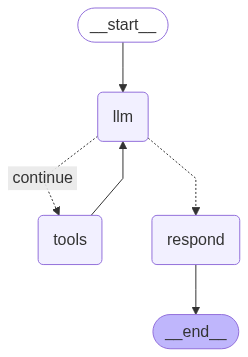

In [53]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
ans = app.invoke({"messages":[("human","Tell me about city details for Surat?")]})['Final_response']

CallModel Input : {'messages': [HumanMessage(content='Tell me about city details for Surat?', additional_kwargs={}, response_metadata={}, id='c1d87056-7b13-4316-85a6-65ab2c756fb7')]}
CallModel response : content='' additional_kwargs={'function_call': {'name': 'get_city_details', 'arguments': '{"prompt": "Surat"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run--7dc008f9-5eba-423a-a7de-18e7382aa98c-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Surat'}, 'id': 'f2a73a27-822d-42a8-88df-02c55b42701c', 'type': 'tool_call'}] usage_metadata={'input_tokens': 29, 'output_tokens': 7, 'total_tokens': 36, 'input_token_details': {'cache_read': 0}}
CallModel Input : {'messages': [HumanMessage(content='Tell me about city details for Surat?', additional_kwargs={}, response_metadata={}, id='c1d87056-7b13-4316-85a6-65ab2c756fb7'), AIMessage(content='', additional_k

In [55]:
ans

CityDetails(state_name='Gujarat', state_capital='Gandhinagar', country_name='India', country_capital='New Delhi', current_temperature='30 degrees Celsius')